In [2]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np

import pandas as pd
pd.set_option('max_colwidth', 200)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import time
import re
import json_lines
import pickle
import sentencepiece as spm

from model import *
from helper_funcs import *

print("using gpu") if tf.test.is_gpu_available else print("gpu not available")

using gpu


# Creating sentence piece vocabulary for Czech sum

In [9]:
json_lines_to_txt("dataset/sumeczech-1.0-train.jsonl", "sp_corpus.txt", dataset_len=len(train_data), proportion=0.5)

In [5]:

spm.SentencePieceTrainer.train(input="sp_corpus.txt", model_prefix="../sp_czechsum_model", vocab_size=50000, input_sentence_size=2_500_000
,user_defined_symbols=['0', '1', '2', '3', '4', '5', '6','7','8', '9'])

In [15]:
sp = spm.SentencePieceProcessor(model_file='sp_czechsum_50K_model.model')

In [50]:
sp.IdToPiece(0)

'<pad>'

In [40]:
sp.PieceToId(["ahoj", "ahoj", "asdlkfj"])

[33813, 33813, 3]

In [60]:
w = "nejobhospodařovávatelnější"
"""
a= sp.EncodeAsIds(w)
print(a)
print(len(a))
a = sp.EncodeAsPieces(w)
print(a)
print(len(a))

print(sp.Decode(a))
"""
r = r"[\w'.,!?;\"]+"
#r = r"?[\w"
"""
print(sp.EncodeAsPieces(w))
print(sp.EncodeAsIds(w))

words = re.findall(r, w)
print(words)
a = []
b = []
for word in words:
    a += (sp.EncodeAsPieces(word))
    #b += (sp.DecodePieces(word))
print(a)
print(sp.PieceToId(a))
"""

a = create_merge_pieces(w, 4, sp)


▁nej
ob
hospoda
ř
ová
v
atel
nější
['▁nejobhospodařovávatelnější']


In [90]:
w = "vládnoucí"; w2 = " garnitůra"; w3= " nemá"; w4 =  " možnost."

w = sp.EncodeAsIds(w)
w2 = sp.EncodeAsIds(w2)
w3 = sp.EncodeAsIds(w3)
w4 = sp.EncodeAsIds(w4)

#print(sp.EncodeAsPieces(w))
print(w, w2, w3, w4)
print(sp.Decode(w + w2 + w3 + w4))

[13713] [4204, 1158, 54, 353] [390] [408, 16]
vládnoucí garnitůra nemá možnost.


In [27]:
sp.Decode([2316, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

'útočník'

In [24]:
b = [0, 0, 218,14,6,4,5,9,4887,809,9532,38,24807,43,19015,18,561,33604,9630,18938,16,295,53,24484,411,16047,42,35564,432,18353,48375,38,16,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42060,6372,32262,3703,42,3632,33604,9630,18938,14,8,15,13,7218,2,0,0,0,0,0,0,0,0]

In [25]:
a, b, c, d = train_data[0]

In [33]:
d

{}

In [8]:
a = [517,7525,19,31,18,2713,116,28560,28,15,2357,5382,273,770,193,16,19976,16480,15,74,19,582,16489,827,210,15,49887,12761,53,169,400,17,179,19,73,517,1999,228,14,5,4,10,4,713,14,6,10,16,6,8,4,289,34,8614,33,572,57,8281,29,184,50001,14,7,5,15,5,14230,38,16,34,2713,19798,21,122,12169,15,13992,32114,7097,48758,42,23418,1403,17,29057,25,2662,89,7879,24,11286,1304,42,1655,2631,16,263,1208,19,3352,3248,9529,15,189,809,8839,48,3830,7525,42767,2,5699,295,17478,50,159,29,17407,15,4567,520,218,34,611,2,0,0,0,0,0,0,0,0,1,333,50001]

# Dataset laoding

## Czech Sum - sentencepiece

In [63]:
selected_columns = ["abstract", "headline"]

for dataset in ["train"]:
    json_lines_to_csv_dataset_sentencepiece(
        selected_columns, 
        f"dataset/sumeczech-1.0-{dataset}.jsonl", 
        f"dataset_sumeczech_sp/sumeczech_sp_{dataset}.csv", 
        VOCAB_SIZE, Tx, Ty, max_global_oov, max_Tx, max_Ty)
    print(f"{dataset} DONE")

train DONE


In [3]:
Tx = int(60 * 1.7) # 102
Ty = int(13 * 1.7) # 22

EPOCHS = 40

BATCH_SIZE = 16
max_global_oov = 3 # not many of them
VOCAB_SIZE = 50_000 ## vocab does not include ! :(

In [3]:
#train_data = read_csv_dataset("dataset_sumeczech_sp/sumeczech_sp_train.csv", Tx, Ty)
val_data = read_csv_dataset("dataset_sumeczech_sp/sumeczech_sp_dev.csv", Tx, Ty)[:500]

NameError: name 'Tx' is not defined

In [3]:
cnt = 0
for a, b, c, d in train_data:
    cnt += list(b).count(0) / len(b)

cnt / len(train_data)

NameError: name 'train_data' is not defined

In [8]:
model = TextSummarizer(Tx, Ty, BATCH_SIZE, VOCAB_SIZE, 
                        embedding_dim=128, a_units=256, h_units=256, word_dict=None, index_dict=None, max_global_oov=max_global_oov, sp_mode=True)

In [11]:
model.load_model(load_prev={"model_name" : "WOW", "epoch" : 3})

model loaded


In [ ]:
model = TextSummarizer(Tx, Ty, BATCH_SIZE, VOCAB_SIZE, 
                        embedding_dim=128, a_units=256, h_units=256, word_dict=None, index_dict=None, max_global_oov=max_global_oov, sp_mode=True)

history = model.fit(
            epochs=EPOCHS, 
            train_data=val_data,
            val_data=val_data,
            lr=0.15,
            use_coverage=True,
            early_stopping=CallbackEarlyStopping(patience=4, min_delta=0),
            reduce_lr=None,
            save_freq=100,
            model_name="TEST",

            restore=True
            )


In [14]:
model = TextSummarizer(Tx, Ty, BATCH_SIZE, VOCAB_SIZE, 
                        embedding_dim=128, a_units=256, h_units=256, word_dict=None, index_dict=None, max_global_oov=max_global_oov, sp_mode=True)

history = model.fit(
            epochs=EPOCHS, 
            train_data=val_data,
            val_data=val_data,
            lr=0.15,
            use_coverage=True,
            early_stopping=CallbackEarlyStopping(patience=4, min_delta=0),
            reduce_lr=None,
            save_freq=100,
            model_name="TEST",

            restore=True
            )

# 6.453955173492432

...
inital learning rate:  0.15
optimizer loaded
restoring checkpoint from: 25/07/2021 13:43:57 epoch: 25 batch_i:  0 38.20516347885132
SDKJFLKDSJF tf.Tensor(6.4880843, shape=(), dtype=float32)
epoch: 26/40         stage: val        batch: 030/31         [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] (96.8%)	loss: 6.08963	t+:0:25s
model saved

epoch: 26 DONE            	avg_train_loss: 6.55046272277832            	exec_time: 0.43min	avg_val_loss: 6.367172718048096
epoch: 27/40         stage: val        batch: 030/31         [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] (96.8%)	loss: 6.90149	t+:0:15s
model saved

epoch: 27 DONE            	avg_train_loss: 6.47194766998291            	exec_time: 0.27min	avg_val_loss: 6.362111568450928
epoch: 28/40         stage: val        batch: 030/31         [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] (96.8%)	loss: 6.41082	t+:0:15s
model saved

epoch: 28 DONE            	avg_train_loss: 6.415095806121826            	exec_time: 0.27min	avg_val_loss: 6.204564571380615
epoch: 29/40       

KeyboardInterrupt: 

## Czech Sum Dataset

In [2]:
with open('word_dict.pickle', 'rb') as f:
    word_dict = pickle.load(f)

index_dict = {}
for key, value in word_dict.items():
    index_dict[value] = key


In [28]:
BATCH_SIZE = 64 # 16 in orig paper
EPOCHS = 3
#Tx = 450 #length of input sequence (article)
#Ty = 50 #length of output sequence (abstract)
Tx = 50
Ty = 12 + 1 # +1 for <eos> token
#max_global_oov = 50
max_global_oov = 5 #!!! increase?????? better more than less, flexibility just for elegance + performance??j
VOCAB_SIZE = len(word_dict)

In [29]:
t0 = time.time()

val_data = read_csv_dataset(f"dataset_csv/sumeczech_dev.csv", Tx, Ty)
#train_data = read_csv_dataset(f"dataset_csv/sumeczech_train.csv", word_dict, VOCAB_SIZE, Tx, Ty)

time.time() - t0

pračiková
zavaleným
zavážet
propadům
spojujících
evakuovaná
frýdštejn
657
zalesněný
kopanina
cihlovou
frontou
hřebenů
přestavila
personalizace
šéfdesignérovi
neodpustil
nbl
psychiatrická
jaroslavě
musilové
síťovém
nezanedbali
23leté
indky
znásilnila
šaší
tharúr


Error: field larger than field limit (131072)

In [8]:
len(train_data)

867603

## CNN-Daily mail dataset

In [4]:
with open('dailymail_word_dict.pickle', 'rb') as f:
    word_dict = pickle.load(f)

index_dict = {}
for key, value in word_dict.items():
    index_dict[value] = key

In [5]:
# stodvacetidolarové ['▁sto', 'dvacet', 'i', 'do', 'lar', 'ové']
# e-neschopenky ['▁e', '-', 'ne', 'schop', 'enky']
#přestavila ['▁pře', 'stav', 'ila']
# jednašedesátiletá ['jedna', 'šedesát', 'iletá']

BATCH_SIZE = 8 # 16 in orig paper
EPOCHS = 3
#Tx = 450 #length of input sequence (article)
Ty = 50 #length of output sequence (abstract)
Tx = 400
Ty = 100 # +1 for <eos> token

max_global_oov = 100

VOCAB_SIZE = len(word_dict)

In [7]:
t0 = time.time()

val_data = read_csv_dataset(f"dataset_dailymail/val.csv", Tx, Ty)
#train_data = read_csv_dataset(f"dataset_dailymail/train.csv", word_dict, VOCAB_SIZE, Tx, Ty)

time.time() - t0

2.646956443786621

from rouge_eval import *

evaluate_model(dataset_path="dataset_dailymail/val.csv", 
               save_dir="",
               use_beam_search=True,
               bw=3,
               save_n_samples=6,
               use_coverage=False,
               batch_size=BATCH_SIZE,
               total_batches=3,
               word_dict=word_dict, index_dict=index_dict, 
               vocab_size=VOCAB_SIZE,
               Tx=Tx, Ty=Ty, max_global_oov=max_global_oov,
               embedding_dim=128, a_units=256, h_units=256
               )

Loading dataset in json lines form into memory

In [6]:
""" dict values: abstract, dataset, filename, headline, length, md5, offset, published, section, subdomain, text """
t0 = time.time()
data = []
selected_columns = ["text", "abstract"]

for dataset in ["dev"]:
    with json_lines.open(f"dataset/sumeczech-1.0-{dataset}.jsonl", 'r') as json_data:
        for line in json_data:
            data.append(line)
        if dataset == "dev": val = pd.DataFrame(data); val = val[selected_columns]
        elif dataset == "oodtest": ood_test = pd.DataFrame(data); ood_test = ood_test[selected_columns]
        elif dataset == "test": test = pd.DataFrame(data); test = test[selected_columns]
        elif dataset == "train": train = pd.DataFrame(data); train = train[selected_columns]
del data
time.time() - t0

1.6024775505065918

In [7]:
sp = spm.SentencePieceProcessor(model_file='sp_czechsum_50K_model.model')

In [8]:
#sp = spm.SentencePieceProcessor(model_file='sp_czechsum_50K_model.model')

t_len = []; sp_len = []

for s in val["text"]:
    #t_len.append(len(re.findall(r"[\w']+|[.,!?;]", s)))
    sp_len.append(len(sp.EncodeAsPieces(s)))


In [9]:
len(sp_len)

44567

In [72]:
sum(t_len) / len(t_len)

9.488837031884579

In [19]:
Tx = 800

In [73]:
(sum(sp_len) / len(sp_len)) / (sum(t_len) / len(t_len))

1.8980512616785963

/home/wenceslai/anaconda3/envs/ml/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


5num summary:  150 399.0 571.0 847.0 20179
num of outlier:  2925
proportion of sentences that are longer than the cutoff
delta > 1  0.3613211569098212
delta < 5:  0.0039042340745394574
5 < delta < 10:  0.0033881571566405635
10 < delta < 20:  0.008661116969955349
20 < delta < 40:  0.01662665200709045
40 < delta < 80:  0.02993246123813584
delta > 80:  0.29402921444117847


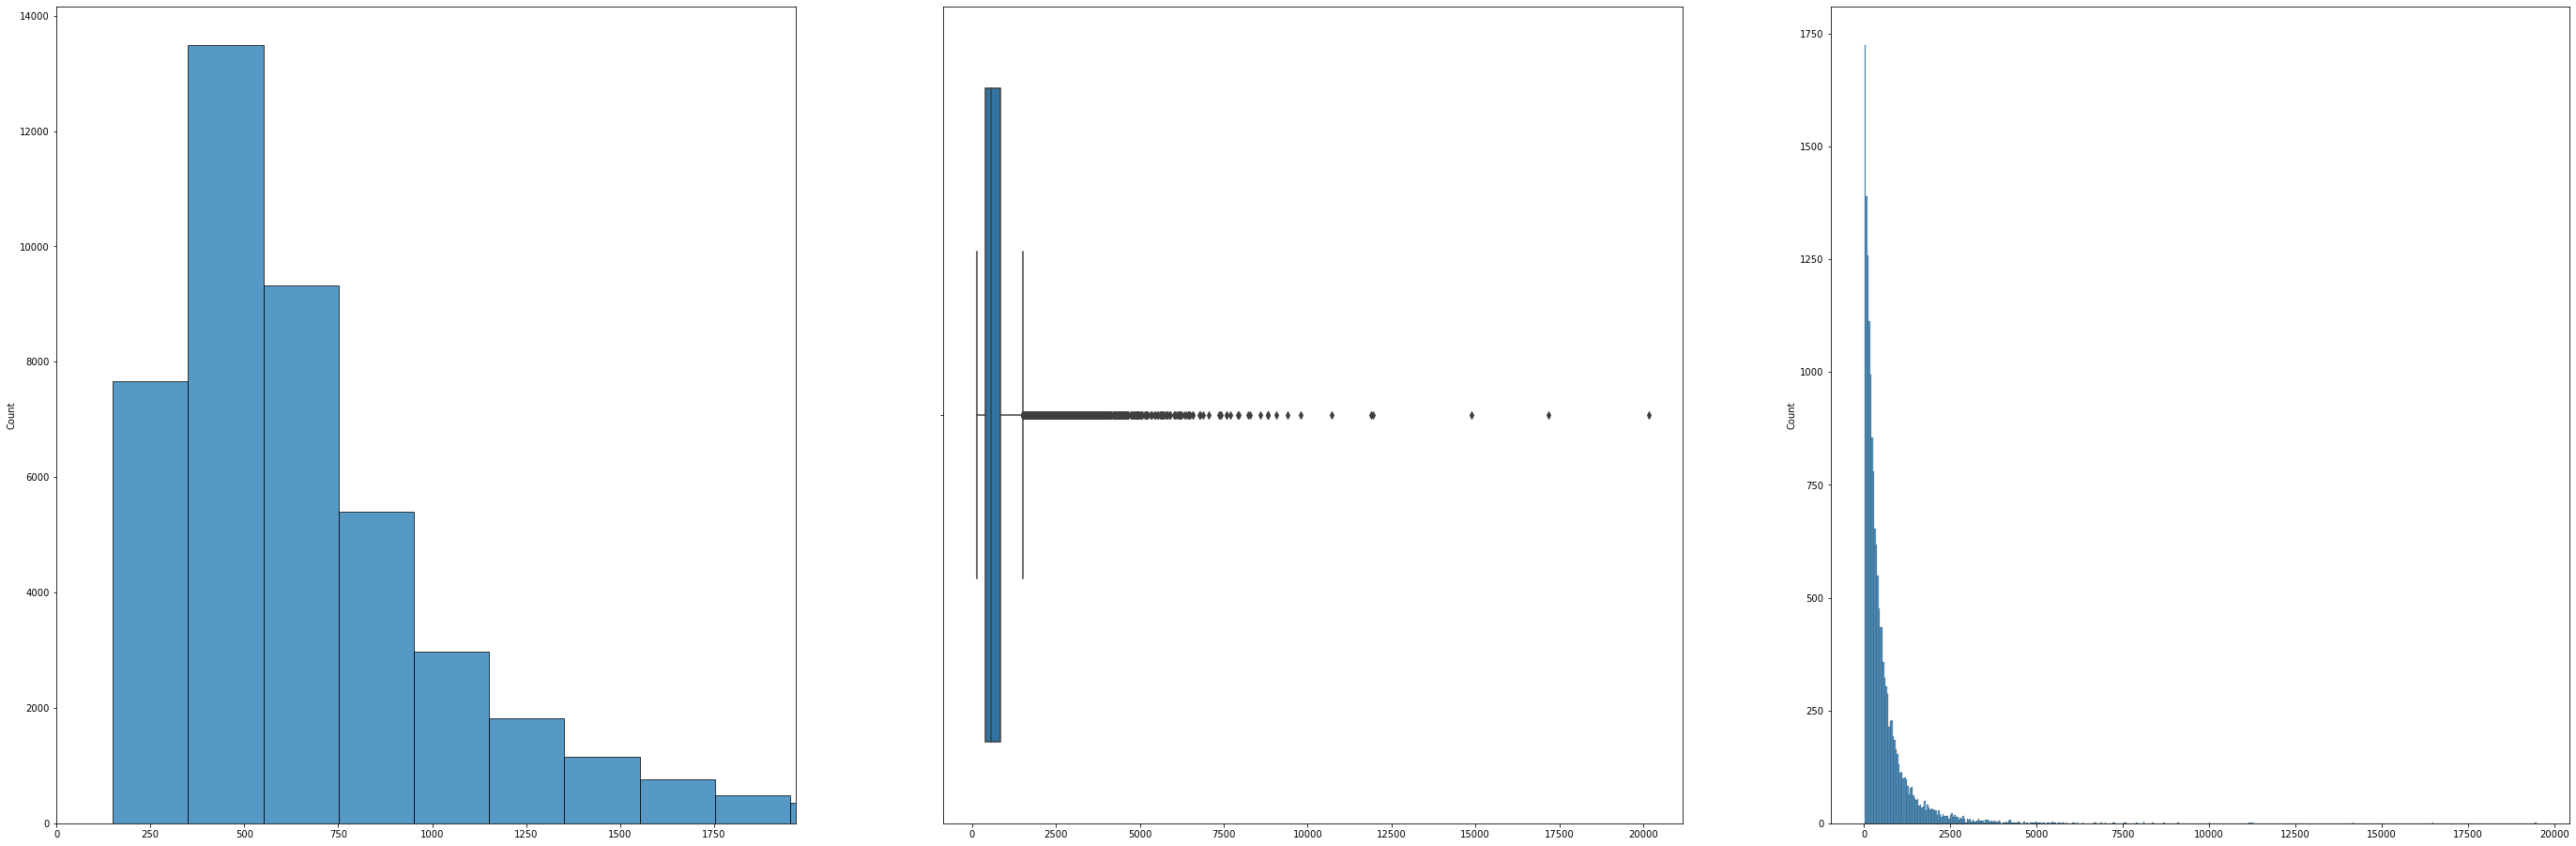

In [18]:
text_len_stats(sp_len, Tx)

Converting json lines files to csv for compatibility with tensorflow and easier manipulation

# Creating datasets in csv form

In [42]:
t0 = time.time()
selected_columns = ["abstract", "headline"]

for dataset in ["train", "dev"]:
    json_lines_to_csv_dataset(
        selected_columns, 
        f"dataset/sumeczech-1.0-{dataset}.jsonl", 
        f"dataset_csv/sumeczech_{dataset}.csv", 
        word_dict, VOCAB_SIZE, Tx, Ty, max_global_oov)
    print(f"{dataset} DONE")

time.time() - t0

train DONE
dev DONE


165.60018825531006

In [14]:
Sigma = 0
for point in val_data:
    a, b, c, d = point
    #print(len(b))
    Sigma += np.count_nonzero(a)

Sigma / len(val_data)


40.50416227253349

Retrieving dataset encoded from csv format

Creating dictionary

In [33]:
t0 = time.time()
#creating a dictionary from train
word_dict = {}
reg = r"[\w']+|[.,!?;]"

for i in range(train.shape[0]):
    for word in re.findall(reg, train.iloc[i]['abstract']) + re.findall(reg, train.iloc[i]['headline']):
        word = word.lower()

        if word not in word_dict.keys(): word_dict[word] = 0

        word_dict[word] += 1

vocab_size = 50000

word_dict = {k : v for k, v in sorted(word_dict.items(), key=lambda x: x[1], reverse=True)[:vocab_size]} #sorting keys by count of occurences 
for i, (word, _) in enumerate(word_dict.items()): word_dict[word] = i + 4 #replacing count values by unique token values
#special tokens
word_dict["<sos>"] = 1 # start of sequence !later used in model
word_dict["<eos>"] = 2 # end of sequence
word_dict["<unk>"] = 3 # unknown token/word
word_dict["<pad>"] = 0 # padding

with open('word_dict.pickle', 'wb') as f:
    pickle.dump(word_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

time.time() - t0

214.57923245429993

In [8]:
for key, value in list(word_dict.items())[0:10]: #removing number > x from dict?, jména politiků,
    print(value, "\t", key)

5 	 .
6 	 ,
7 	 v
8 	 na
9 	 a
10 	 se
11 	 z
12 	 je
13 	 s
14 	 o


Opening the dictionary

# Determining lengths of input and output sequences (Tx and Ty)
setting Tx and Ty on heuristicaly from graph information

In [9]:
text_lens = []
abstract_lens = []

for i in range(val.shape[0]):
    text_lens.append(len(re.findall(r"[\w']+|[.,!?;\"]", val.iloc[i]['abstract'])))
    abstract_lens.append(len(re.findall(r"[\w']+|[.,!?;\"]", val.iloc[i]['headline'])))

In [22]:
sum(text_lens) / len(text_lens)

43.64271770592591

In [18]:
cnt = 0
for l in text_lens:
    if l <= Tx + 10: cnt += 1
print(cnt / len(text_lens))
cnt=0
for l in abstract_lens: 
    if l <= 12: cnt += 1
print(cnt / len(text_lens))


NameError: name 'Tx' is not defined

/home/wenceslai/anaconda3/envs/ml/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/wenceslai/anaconda3/envs/ml/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/wenceslai/anaconda3/envs/ml/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/wenceslai/anaconda3

(0, 50)

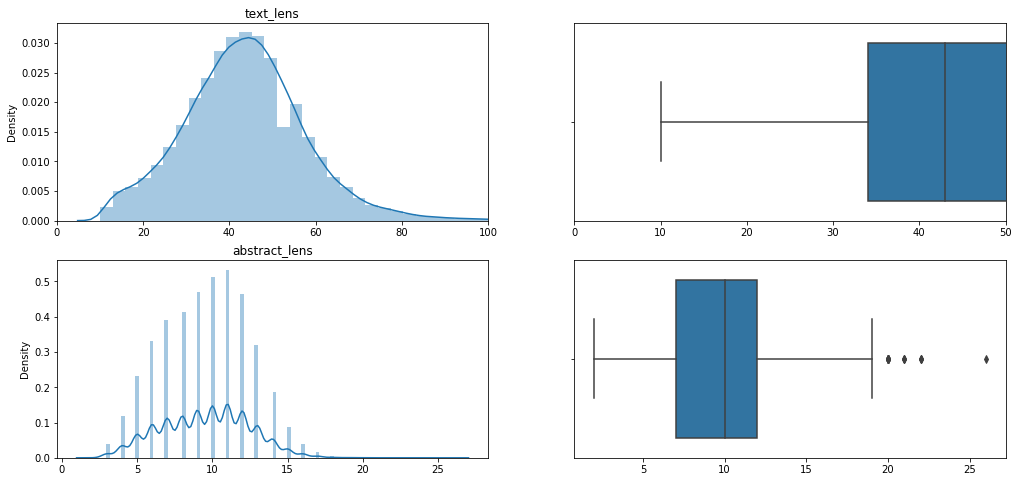

In [20]:
fig, ax = plt.subplots(2,2, figsize=(17,8))
sns.distplot(text_lens, bins=100, ax=ax[0, 0])
sns.distplot(abstract_lens, bins=100, ax=ax[1, 0])

sns.boxplot(text_lens, ax=ax[0, 1])
sns.boxplot(abstract_lens, ax=ax[1, 1])

ax[0, 0].set_title("text_lens")
ax[1, 0].set_title("abstract_lens")

ax[0, 0].set_xlim([0, 200])
ax[0, 1].set_xlim([0, 50])

In [50]:
print(f"median text len: {text_lens[len(text_lens) // 2]}")
print(f"median abstract len: {abstract_lens[len(abstract_lens) // 2]}")

median text len: 48
median abstract len: 11


In [ ]:
""" 
Ideas:
try shorter input seq if attention over words is not enough
add attention over sentences

Notes:
dimensions batch x examples x features

change h_units, a_units
try adding bilstm layers
investigate why does first pass takes so long
"""

In [37]:
Q1, Q2, Q3 = np.percentile(text_lens, [25, 50, 55])

/home/wenceslai/anaconda3/envs/ml/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


5num summary:  2 7.0 10.0 12.0 26
num of outlier:  18
proportion of sentences that are longer than the cutoff
delta > 1  0.08095676172953081
delta < 5:  0.07895976843853075
5 < delta < 10:  0.0009424013283371104
10 < delta < 20:  2.2438126865169297e-05
20 < delta < 40:  0.0
40 < delta < 80:  0.0
delta > 80:  0.0


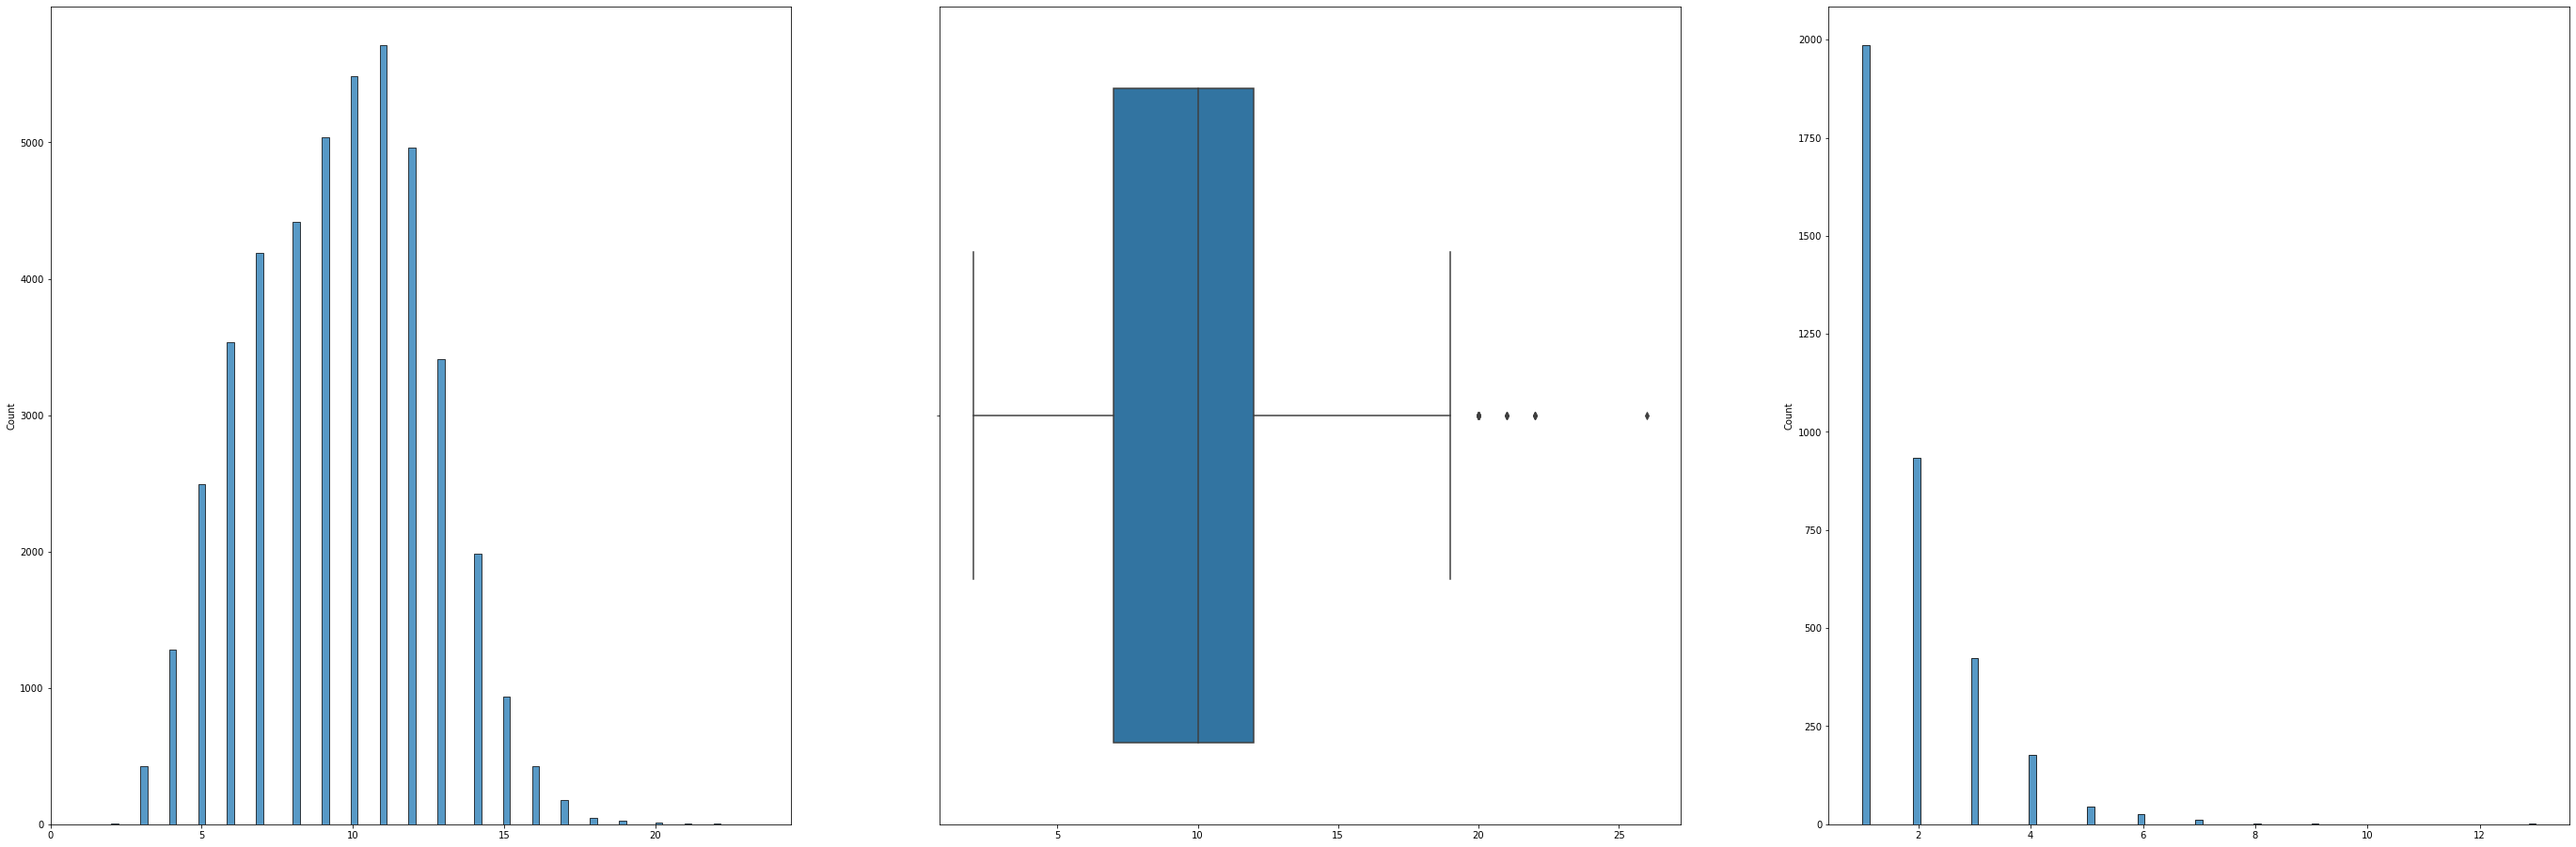

In [33]:
text_len_stats(abstract_lens, T=13)

/home/wenceslai/anaconda3/envs/ml/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


5num summary:  10 34.0 43.0 52.0 303
num of outlier:  706
proportion of sentences that are longer than the cutoff
delta > 1  0.1026768685350147
delta < 5:  0.03518298292458546
5 < delta < 10:  0.020867457984607447
10 < delta < 20:  0.020912334238337785
20 < delta < 40:  0.010725424641550923
40 < delta < 80:  0.0029393946193371776
delta > 80:  0.0005609531716292324


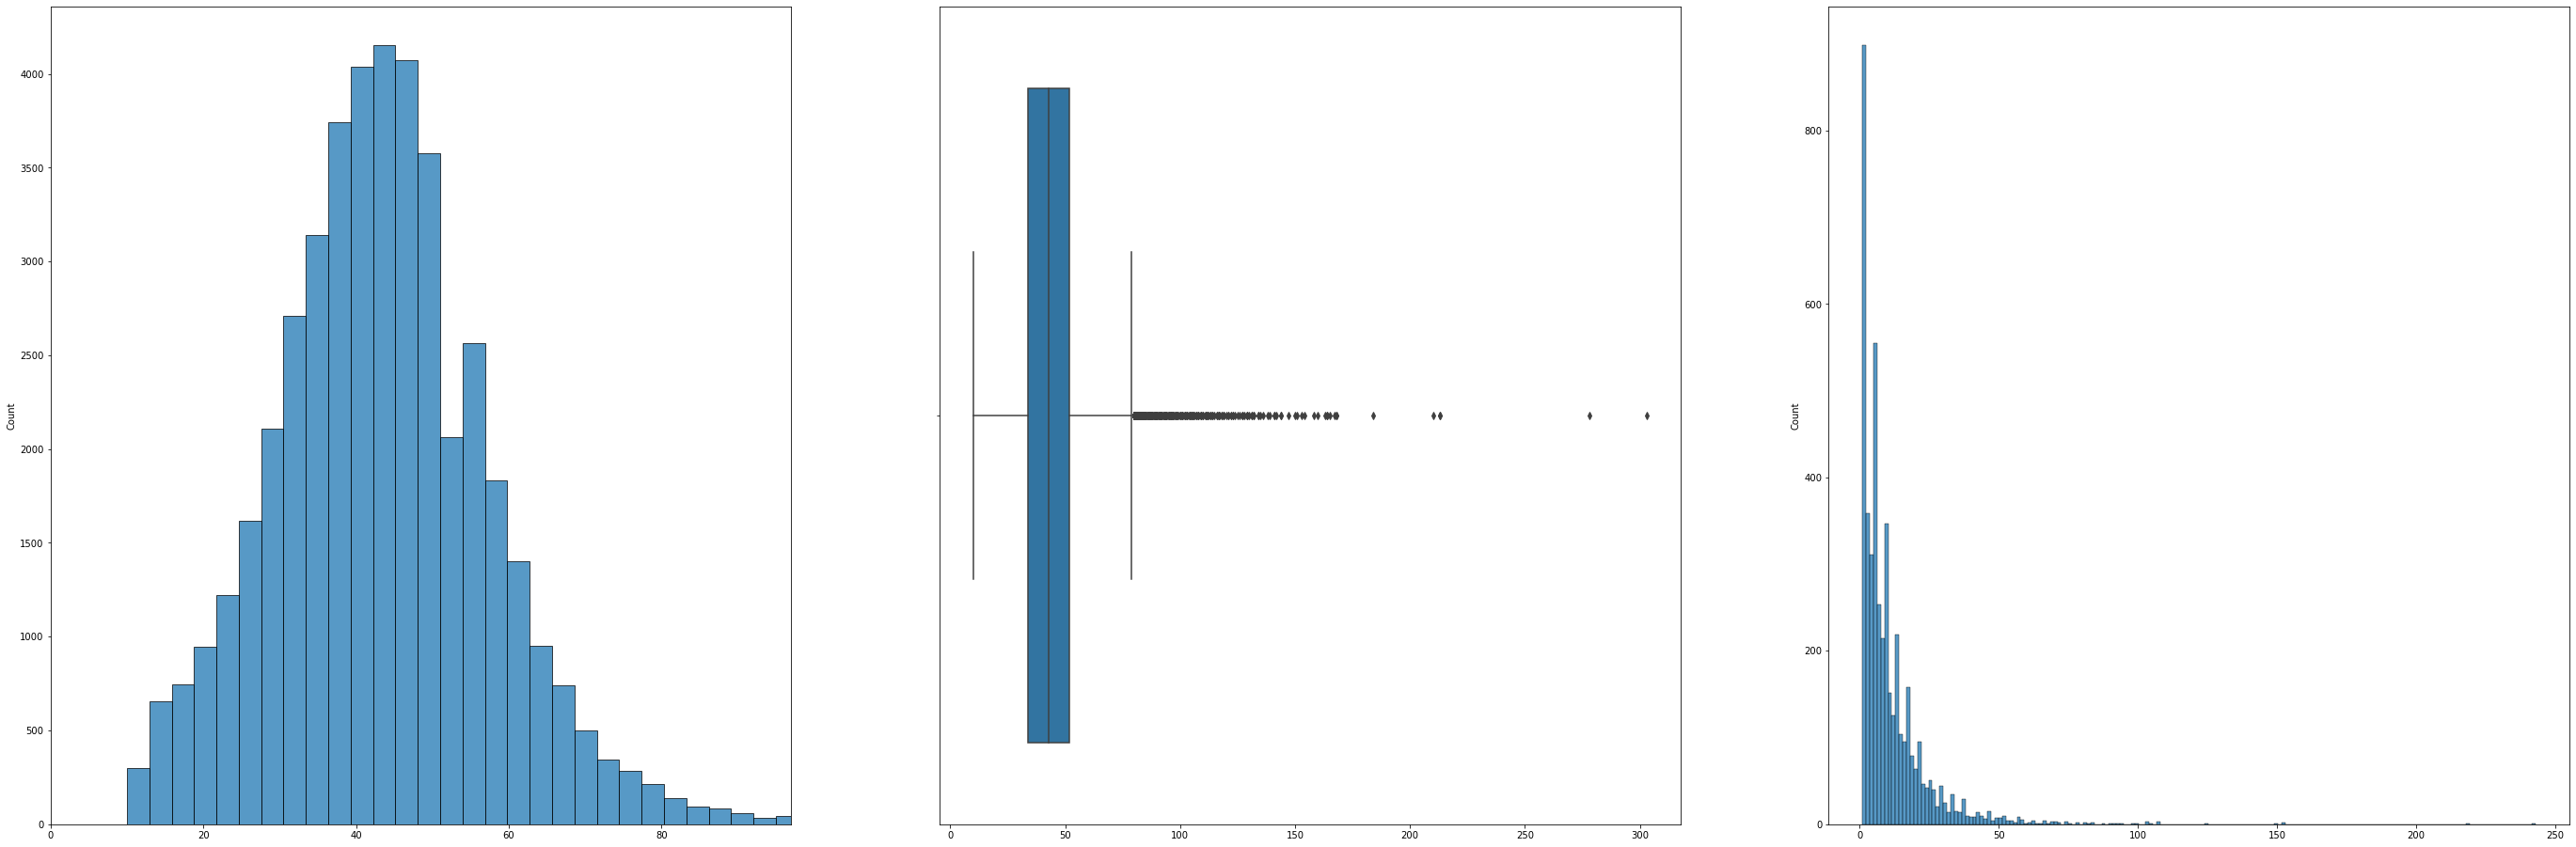

In [28]:
text_len_stats(text_lens, T=60)

5num summary:  0 [15. 23. 24.] 50


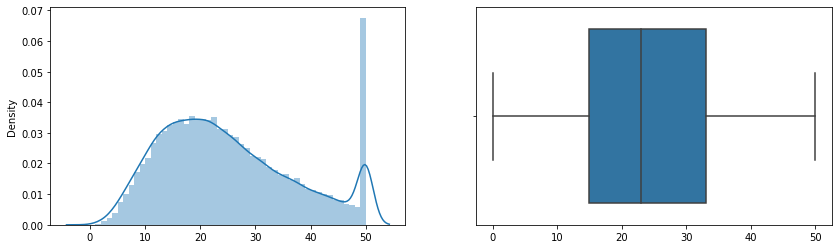

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))
sns.distplot(oov_cnts, ax=ax[0])
sns.boxplot(oov_cnts, ax=ax[1])
print("5num summary: ", np.min(oov_cnts), np.percentile(oov_cnts, [25, 50, 55]), np.max(oov_cnts))

In [16]:
    def ext_to_unk(index):
        if index >= VOCAB_SIZE: #############..greater tha equals??
            return word_dict["<unk>"]
        else: return index

In [32]:
X_batch_ext = []; y_batch = []; oov_cnts = []; oov_vocabs = []; X_batch = []; y_batch_teacher_force = []
                
for i in range(len(val_data)):
                     X_ext, y_ext, oov_cnt, oov_vocab = val_data[i]

                     #X_batch.append(list(map(ext_to_unk, X_ext)))
                     #y_batch_teacher_force.append(list(map(ext_to_unk, y_ext)))
                     #X_batch_ext.append(X_ext)
                     #y_batch.append(y_ext)
                     oov_cnts.append(oov_cnt) 
                     #oov_vocabs.append(oov_vocab)

# model training

In [5]:
model = TextSummarizer(Tx, Ty, BATCH_SIZE, VOCAB_SIZE, 
                        embedding_dim=128, a_units=256, h_units=256, word_dict=word_dict, index_dict=index_dict, max_global_oov=max_global_oov)

In [6]:
model.load_model()

model loaded


In [8]:
history = model.fit(
            epochs=EPOCHS, 
            train_data=val_data,
            val_data=val_data,
            lr=0.15,
            use_coverage=False,
            early_stopping=CallbackEarlyStopping(patience=2, min_delta=0.001),
            reduce_lr=None,
            save_freq=100,
            
            restore=True
            )

...
inital learning rate:  0.15


ResourceExhaustedError:  [_Derived_]  OOM when allocating tensor with shape[395264] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node concat_1_0}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[decoder_50/lstm_1/StatefulPartitionedCall]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[clip_by_global_norm/mul_12/_624]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_step_371752]

Function call stack:
train_step -> train_step -> train_step


# beam search for 1 batch

In [5]:
model = TextSummarizer(Tx, Ty, 2, VOCAB_SIZE, 
                        embedding_dim=128, a_units=256, h_units=256, word_dict=None, index_dict=None, max_global_oov=max_global_oov + 1, sp_mode=True)

model.load_model()


model loaded


In [8]:
X_batch, X_batch_indeces_ext, _, y_batch, max_oov, oov_vocabs = model.get_batch(8, val_data)

In [17]:
#Mars or, passengers of pizza passengers should be used..................... And.... And.. Is and..... And.. Of and.... Of and.... Of and... Feel like the unwell
# dell opouští hp, dell oznámí zprávy o světové válce
pred_sentences_batch, a, sen = model.beam_decode_batch(X_batch, X_batch_indeces_ext, 3, 2, False, block_unk=False)

pred_sentences_batch = pred_sentences_batch.numpy()
print(pred_sentences_batch)

for i, sentence in enumerate(pred_sentences_batch):
    print(i, model.indeces_to_words(sentence, oov_vocabs[i], remove_paddings=True, model_file="sp_czechsum_50K_model.model"))
    print(a[i].numpy())
    print("")

sen = sen.numpy()
for sentence in sen:
    print(model.indeces_to_words(sentence, oov_vocabs[0], remove_paddings=False, model_file="sp_czechsum_50K_model.model"))


[[0.16507502 0.14679915 0.04836432]
 [0.13119218 0.11407856 0.06249027]]
[    6    14 41161]
[41161   306    97]
[11158    39     4]
[    4 13408   448]
[ 109 3533    4]
[   39 13408    29]
[16 17 37]
[   49    37 32351]
[11158    15    39]
[13408    21    21]
[ 4 74 17]
[  4 834  37]
[109  17  37]
[  273 10193    25]
[   14    20 11630]
[ 5  7 64]
[4 4 9]
[    4     4 20215]
[  4   4 177]
[13408   555   175]
[ 273 7323    4]
[[41161     6     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]
 [ 8136  1099     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]]
0 syřané2
[0.]

1 free zprávy
[0.]

syřané
ham
firma
syřané2
ham 
firma syřané
ham  syřané
ham  chce
syřané2á
ham  syřané závodech
ham  syřané si
ham  syřané0
ham  syřané závodech0
ham  syřané závodech sněhem
ham  syřané si firma
ham  syřané závodech sněhemme
ham  syřané závodech sněhemdají
ham

In [ ]:
[470]
 [ 15]]
[[ 6660]
 [26550]]
[[  14]
 [3683]]
[[  5]
 [105]]
[[ 5]
 [15]]
[[   9]
 [5792]]
[[102]
 [ 45]]
[[  16]
 [9520]]
[[6147]
 [  16]]
[[  19]
 [3683]]
[[ 15]
 [105]]
[[74]
 [19]]
[[  19]
 [3053]]
[[5135]
 [  18]]
[[9068]
 [1170]]
[[4061]
 [ 574]]
[[33]
 [ 2]]
[[2]
 [0]]
[[0]
 [0]]
[[0]
 [0]]
[[0]
 [0]]
0 olomoucké nemocnice slaví 115 let. podívejte se, jak se měří lampiony
[1.]

In [20]:
pred_sentences_batch, a, u = model.beam_decode_batch(X_batch, X_batch_indeces_ext, 2, 2, False, block_unk=False)

pred_sentences_batch = pred_sentences_batch.numpy()

for i, sentence in enumerate(pred_sentences_batch):
    print(i, model.indeces_to_words(X_batch[i], oov_vocabs[i], remove_paddings=False, model_file="sp_czechsum_50K_model.model"))
    print(i, model.indeces_to_words(y_batch[i], oov_vocabs[i], remove_paddings=False, model_file="sp_czechsum_50K_model.model"))
    print(i, model.indeces_to_words(sentence, oov_vocabs[i], remove_paddings=True, model_file="sp_czechsum_50K_model.model"))
    print("")

[[0.16507502 0.14679915]
 [0.13119218 0.11407856]]
[29335    39]
[306 448]
[18 58]
[ 539 2207]
[2861  122]
[407  58]
[ 17 301]
[333  58]
[58 17]
[15 19]
[  58 3479]
[19 17]
[14 24]
[ 5 80]
[4 9]
[   17 20215]
[58 14]
[19  5]
[19  4]
[ 182 8586]
[ 58 142]
0 potravinářská firma hamé nabízí zajištění ubytování a práci ve svých závodech pro zhruba deset syrských rodin. v budoucnu by se počty mohly zvýšit, uvedla v pondělí společnost v tiskové zprávě. syřané si podle firmy azyl v česku zaslouží.
0 máme ubytování i práci pro deset syrských rodin, nabídlo hamé pomoc
0 syřané potah

1 hypermoderní lyžařská aréna silvretta nad rakouským ischglem hýčká své návštěvníky 200 kilometry sjezdovek a lanovkami s koženým potahem. ovšem nejde jen o luxus, jak potvrzují zdejší terény. bezmála třítisícové vrcholky dobře zásobené sněhem jsou bezednou studnou freeridu.
1 ischgl tisíc a jeden freeride
1 free zprávy



In [ ]:
#15 americká společnost dell computer se stala největším výrobcem osobních počítačů na světě a na druhé místo tak odsunula firmu hewlettpackard. dell se tak vrátil zpět na první příčku, kde byl už loni ve třetím čtvrtletí i před fúzí firem hewlettpackard a compa ⁇  computer.
#15 dell je největším světovým výrobcem pc ⁇  odsunul firmu hewlett
#15 dell opouští hp, dell oznámí zprávy o světové válce

# dirty validation without beam search

In [18]:
total_val_batches = len(val_data) // BATCH_SIZE
val_epoch_loss = 0
rouge_scores = []
predictions = []
oov_vocabs = []
x = []
y = []
losses = []

for batch_i in range(0, total_val_batches):

  X_batch, X_batch_indeces_ext, _, y_batch, max_oov, oov_vocab = model._get_batch(batch_i, val_data)
                                        
  loss, rouge, preds = model.evaluate(X_batch, y_batch, X_batch_indeces_ext, max_oov, use_coverage=False, compute_rouge=True)
  
  losses.append(loss.numpy())
  rouge_scores.append(rouge.numpy())
  predictions.append(preds.numpy())
  oov_vocabs.append(oov_vocab)
  x.append(X_batch_indeces_ext)
  y.append(y_batch)

  print(f"\r{batch_i}/{total_val_batches}", end="")
  #print(rouge)



0/1671WARNING:tensorflow:Unresolved object in checkpoint: (root).lstm.cell.state_size
5/1671

KeyboardInterrupt: 

In [27]:
b = 5

t = [[] for _ in range(BATCH_SIZE)]

for i in range(len(x[b])): 
  t[x[b][i, 0]].append(x[b][i, 1])

text = [fix_text(model.indeces_to_words(seq, oov_vocab, remove_paddings=True)) for seq, oov_vocab in zip(t, oov_vocabs[b])]
y_summ = [fix_text(model.indeces_to_words(seq, oov_vocab, remove_paddings=True)) for seq, oov_vocab in zip(y[b], oov_vocabs[b])]
y_hat_summ = [fix_text(model.indeces_to_words(seq, oov_vocab, remove_paddings=True)) for seq, oov_vocab in zip(predictions[b], oov_vocabs[b])]


for i in range(len(y)):
  print("x:", text[i])
  print("")
  print("gold:", y_summ[i])
  print("")
  print("pred:", y_hat_summ[i])
  #print(rouge_scores[0][i])
  print("------------------------------------\n")

print(rouge_scores[b])

x: Glasgow warriors will hope their nine returning scotland internationals will be fired up by thoughts of revenge as they take on leinster on friday night. Stuart hogg, tommy seymour, mark bennett, finn russell, fraser brown, tim swinson and rob harley have been named in the starting xv for the guinness pro12 clash, while jonny gray and adam ashe both start on the bench at the rds arena. All nine featured for the dark blues as they ended their rbs 6 nations with a fifth and final defeat to ireland last sunday. Stuart hogg right looks dejected as scotland are beaten by ireland in their final six nations match. But they will have extra motivation for their club return as they take on a leinster outfit that features seven of joe schmidt's victorious side from murrayfield in their matchday 23. Ian madigan, eoin reddan, marty moore and jordi murphy all start, while sean cronin, cian healy and luke fitzgerald are named among the replacements just six days on from playing winning roles in th

In [ ]:
"""
reverse order of input
leraning rate?
add modified dataset diff eos
test saving models on gcloud
1cycle policy?
"""

In [28]:
history = model.history

Text(0.5, 1.0, 'val_acc')

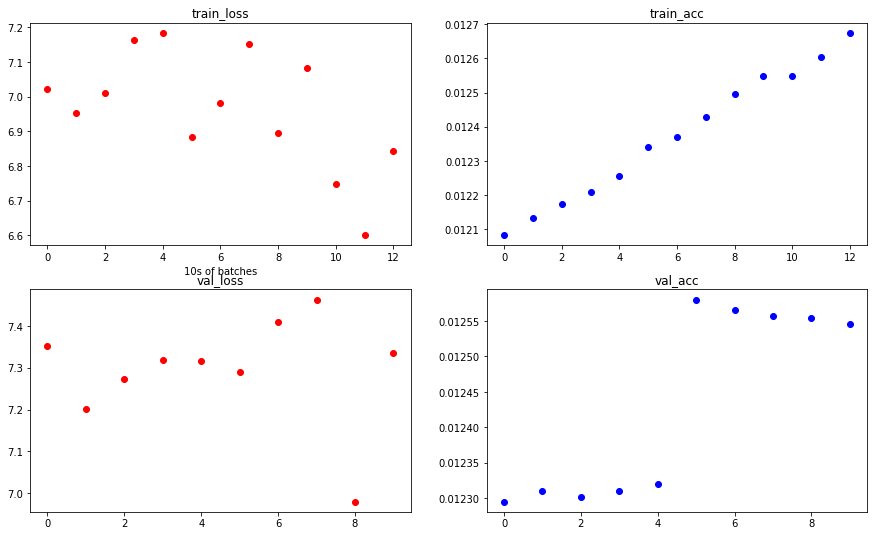

In [29]:
fig, ax = plt.subplots(2,2, figsize=(15,9))
ax[0, 0].plot(range(len(history['train_loss'])), history['train_loss'], 'ro', label='val_acc')
ax[0, 1].plot(range(len(history['train_acc'])), history['train_acc'], 'bo')
ax[1, 0].plot(range(len(history['val_loss'])), history['val_loss'], 'ro')
ax[1, 1].plot(range(len(history['val_acc'])), history['val_acc'], 'bo')

ax[0, 0].set_title("train_loss")
ax[0, 0].set_xlabel("record each 10th batch")
ax[0, 1].set_title("train_acc")
ax[1, 0].set_title("val_loss")
ax[1, 1].set_title("val_acc")